In [1]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import validation_curve

from sklearn import model_selection
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

In [2]:
import sklearn

In [3]:
pd.set_option('display.max_columns',None)

## Import cleaned dataset
### Simple model using just Abn% + demographics

In [4]:
pos_final_test = pd.read_csv('../data/pos_KNN_final_test_trimmed_male.csv.gz', compression='gzip')

non_lab_cols = [ 'age',\
                'ethnicity_AMERICAN INDIAN/ALASKA NATIVE', 'ethnicity_ASIAN','ethnicity_BLACK/AFRICAN AMERICAN', 'ethnicity_HISPANIC/LATINO','ethnicity_OTHER', 'ethnicity_UNKNOWN',\
                'ed_length', 'insurance_Medicare','insurance_Medicaid'\
               'pneumoia', 'diabetes','hypertension' ,'atherosclero','renal_failure' ,'arrhythmia']
model_cols = pos_final_test.columns.str.contains('max')|pos_final_test.columns.str.contains('min')|pos_final_test.columns.str.contains('abn')|pos_final_test.columns.str.contains('mean') | pos_final_test.columns.str.contains('below') |pos_final_test.columns.str.contains('above') | pos_final_test.columns.isin(non_lab_cols)
hadm_features = pos_final_test.loc[:, model_cols]
hadm_target = pos_final_test.loc[:, 'pos']

In [5]:
# from sklearn import preprocessing
# le = preprocessing.LabelEncoder()
# hadm_features['ethnicity'] = le.fit_transform(hadm_features['ethnicity'])
# hadm_features['gender'] = le.fit_transform(hadm_features['gender'])

# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# hadm_features['age'] = scaler.fit_transform(hadm_features['age'].values.reshape(-1, 1))

In [6]:
# hadm_features.corr()

## Train test split

In [7]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(hadm_features, hadm_target, test_size=.2, stratify=hadm_target, random_state=25)

In [8]:
# Over and under sample the train set
sm = SMOTE()
X_res_over, y_res_over = sm.fit_resample(X_train, y_train)

nm = NearMiss()
X_res_under, y_res_under = nm.fit_resample(X_train, y_train)

In [9]:
# check target counts
print('Target=0: ',hadm_target[hadm_target==0].count())
print('Target=1: ',hadm_target[hadm_target==1].count())

Target=0:  7209
Target=1:  1418


In [20]:
1418/(7209+1418)

0.1643676828561493

## Functions used in this notebook

In [10]:
def results(model):
    '''
    Function to report on the metrics of a GridSearch model.
    Input: GridSearchCV model
    Prints: CV score, best parameters, accuracy, precision, recall, F1, confusion matrix and ROCAUC
    '''
    
#     cross validation scores
    print("Cross Validation")
    print("-" * 20)
    print("Best parameter: ", model.best_params_)
    print("Best CV score:  %.4f" % model.best_score_)

#     confusion matrix & related scores
    pred = model.best_estimator_.predict(X_test)
    print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
    print("_______________________________________________")
    print("Classification Report:", end='')
    print(f"\tPrecision Score: {precision_score(y_test, pred) * 100:.2f}%")
    print(f"\t\t\tRecall Score: {recall_score(y_test, pred) * 100:.2f}%")
    print(f"\t\t\tF1 score: {f1_score(y_test, pred) * 100:.2f}%")
    print(f"\t\t\tROC_AUC score: {roc_auc_score(y_test, pred) * 100:.2f}%")
    print("_______________________________________________")
    print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")
    
    svc_disp = plot_roc_curve(model, X_test, y_test)
    plt.show()
    
    if model.estimator.__class__== sklearn.linear_model._logistic.LogisticRegression:
        est_coefs = pd.Series(model.best_estimator_.coef_[0], index=X_train.columns)
        sortedCoefs = np.abs(est_coefs).sort_values(ascending=False)
        print(sortedCoefs[sortedCoefs > 0].head(25))
      
    else:
        est_coefs = pd.Series(model.best_estimator_.feature_importances_, index=X_train.columns)
        sortedCoefs = est_coefs.sort_values(ascending=False)
        print(sortedCoefs.head(25))

In [11]:
def change_threshold(model, threshold_list, X=X_test):
    '''
    Input a model and threshold_list.
    Output scores based on prediction made with threshold list.
    '''
    metrics = pd.DataFrame(columns = ['Threshold','F1','ROC_AUC','Recall','Accuracy','Precision'])
    
    for threshold in threshold_list:
        prob = model.best_estimator_.predict_proba(X)[:,1]
        pred = np.where(prob>threshold,1,0)


        f1 = f1_score(y_test, pred)
        roc_auc = roc_auc_score(y_test, pred)
        recall = recall_score(y_test, pred)
        accuracy = accuracy_score(y_test, pred)
        precision = precision_score(y_test, pred)

        metrics = metrics.append({'Threshold':threshold,
                                  'F1':f1,
                                  'ROC_AUC':roc_auc,
                                  'Recall':recall,
                                  'Accuracy':accuracy,
                                  'Precision':precision}
                                 ,ignore_index=True)
        
    plt.plot(metrics.Threshold, metrics.Recall, label='Recall', color='green')
    plt.plot(metrics.Threshold, metrics.Precision, label='Precision', color='blue')
    plt.plot(metrics.Threshold, metrics.ROC_AUC, label='ROC_AUC', color='red')
    plt.legend()
    plt.xlabel('Threshold')
    plt.ylabel('Scores')
    return metrics

In [12]:
def plot_val_curve(estimator, feature, feature_range, X, y):
    '''
    Plots validation curve for an estimator and a feature for a specified feature range.
    Used to determine range of feature to use for hyperparameter tuning for GridSearchCV.
    '''
    train_scores, valid_scores = validation_curve(estimator, 
                                                  X,y,
                                                  feature,
                                                  feature_range, 
                                                  scoring='roc_auc',cv=3)
    plt.plot(feature_range,train_scores)
    plt.plot(feature_range,valid_scores,linestyle='--')
    plt.xlabel(feature)
    plt.ylabel('roc_auc')

In [13]:
def gather_best_features(model_list):
    best_features = pd.DataFrame()

    for model, model_name, X in model_list:
        if model.estimator.__class__== sklearn.linear_model._logistic.LogisticRegression:
            est_coefs = pd.Series(model.best_estimator_.coef_[0], index=X.columns)
        else:
            est_coefs = pd.Series(model.best_estimator_.feature_importances_, index=X.columns)
            
        sortedCoefs = np.abs(est_coefs).sort_values(ascending=False)
        sorted_df = pd.DataFrame(sortedCoefs).reset_index().rename(columns={"index":'features', 0: model_name})
        best_features = pd.concat([best_features, sorted_df], axis=1)
    return best_features

## Logistic Regression

### Basic

In [14]:
%%time

params ={'C':np.linspace(1e-2,1,20)}
logReg = LogisticRegression(penalty = 'l1', max_iter = 2000, class_weight = "balanced", solver = 'liblinear')

# grid_log = GridSearchCV(estimator = logReg, param_grid = params, cv = 3, scoring='roc_auc')
# grid_log.fit(X_train, y_train)

CPU times: user 231 µs, sys: 18 µs, total: 249 µs
Wall time: 757 µs


In [15]:
threshold_list = np.linspace(0.01,0.5,10)
# change_threshold(grid_log, threshold_list, X_test)

In [16]:
from sklearn.feature_selection import RFECV
selector = RFECV(logReg, step=1, cv=5, scoring ='roc_auc')
selector = selector.fit(X_train, y_train)
selector.support_

array([ True,  True,  True, False, False,  True, False,  True, False,
        True, False,  True,  True, False,  True,  True,  True, False,
        True,  True,  True,  True, False,  True,  True,  True, False,
        True, False, False,  True, False,  True,  True,  True,  True,
        True,  True,  True, False, False, False,  True, False, False,
       False,  True, False, False,  True,  True, False,  True, False,
       False,  True,  True,  True, False,  True,  True,  True, False,
        True,  True, False, False, False,  True,  True, False,  True,
        True, False,  True, False,  True, False,  True,  True,  True,
        True, False,  True, False,  True,  True, False,  True,  True,
        True,  True,  True, False,  True, False,  True,  True,  True,
        True, False,  True,  True,  True])

In [17]:
X_reduced = X_train.iloc[:,selector.support_]
grid_log_reduced = GridSearchCV(estimator = logReg, param_grid = params, cv = 3, scoring='roc_auc')
grid_log_reduced.fit(X_reduced, y_train)

GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=2000, penalty='l1',
                                          solver='liblinear'),
             param_grid={'C': array([0.01      , 0.06210526, 0.11421053, 0.16631579, 0.21842105,
       0.27052632, 0.32263158, 0.37473684, 0.42684211, 0.47894737,
       0.53105263, 0.58315789, 0.63526316, 0.68736842, 0.73947368,
       0.79157895, 0.84368421, 0.89578947, 0.94789474, 1.        ])},
             scoring='roc_auc')

In [18]:
est_coefs = pd.Series(grid_log_reduced.best_estimator_.coef_[0], index=X_reduced.columns)
sortedCoefs = np.abs(est_coefs).sort_values(ascending=False)
sortedCoefs[sortedCoefs>0]

atherosclero                                          0.757705
age                                                   0.593827
('max', 'Bicarbonate - Blood - Chemistry')            0.457339
('max', 'Anion Gap - Blood - Chemistry')              0.449200
ethnicity_ASIAN                                       0.389339
                                                        ...   
('above_max', 'MCV - Blood - Hematology')             0.033939
('mean', 'Magnesium - Blood - Chemistry')             0.026611
('abn_percent', 'Hematocrit - Blood - Hematology')    0.018278
diabetes                                              0.016839
('below_min', 'Sodium - Blood - Chemistry')           0.015814
Length: 63, dtype: float64

In [19]:
X_test_reduced = X_test.iloc[:,selector.support_]

In [21]:
threshold_list = np.linspace(0.1,0.3,25)

,Threshold,F1,ROC_AUC,Recall,Accuracy,Precision
0,0.100000,0.328688,0.597754,0.996479,0.330243,0.196801
1,0.108333,0.332160,0.603995,0.996479,0.340672,0.199296
2,0.116667,0.336943,0.612237,0.985915,0.361530,0.203193
3,0.125000,0.342575,0.621545,0.978873,0.381808,0.207618
4,0.133333,0.348153,0.630560,0.978873,0.396871,0.211729
5,0.141667,0.351746,0.636081,0.975352,0.408459,0.214562
6,0.150000,0.358576,0.646483,0.975352,0.425840,0.219667
7,0.158333,0.363397,0.653391,0.971831,0.439745,0.223482
8,0.166667,0.368139,0.659952,0.968310,0.453071,0.227273
9,0.175000,0.375940,0.670701,0.968310,0.471031,0.233249


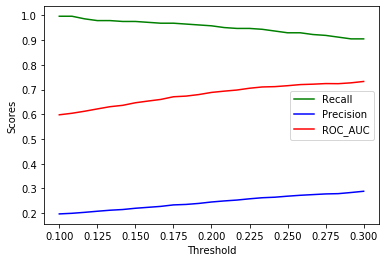

In [22]:
change_threshold(grid_log_reduced, threshold_list, X_test_reduced)

In [23]:
# (2nd round of feature reduction) Remove features with coef 0 and run lasso logistic regression again
X_train_reduced_2 = X_train.loc[:,sortedCoefs[sortedCoefs>0].index]
X_test_reduced_2 = X_test.loc[:,sortedCoefs[sortedCoefs>0].index]
grid_log_reduced_2 = GridSearchCV(estimator = logReg, param_grid = params, cv = 3, scoring='roc_auc')
grid_log_reduced_2.fit(X_train_reduced_2, y_train)

GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=2000, penalty='l1',
                                          solver='liblinear'),
             param_grid={'C': array([0.01      , 0.06210526, 0.11421053, 0.16631579, 0.21842105,
       0.27052632, 0.32263158, 0.37473684, 0.42684211, 0.47894737,
       0.53105263, 0.58315789, 0.63526316, 0.68736842, 0.73947368,
       0.79157895, 0.84368421, 0.89578947, 0.94789474, 1.        ])},
             scoring='roc_auc')

In [24]:
grid_log_reduced_2.best_estimator_.get_params

<bound method BaseEstimator.get_params of LogisticRegression(C=0.16631578947368422, class_weight='balanced',
                   max_iter=2000, penalty='l1', solver='liblinear')>

,Threshold,F1,ROC_AUC,Recall,Accuracy,Precision
0,0.100000,0.328688,0.597754,0.996479,0.330243,0.196801
1,0.108333,0.332160,0.603995,0.996479,0.340672,0.199296
2,0.116667,0.336943,0.612237,0.985915,0.361530,0.203193
3,0.125000,0.342575,0.621545,0.978873,0.381808,0.207618
4,0.133333,0.348153,0.630560,0.978873,0.396871,0.211729
5,0.141667,0.351746,0.636081,0.975352,0.408459,0.214562
6,0.150000,0.358576,0.646483,0.975352,0.425840,0.219667
7,0.158333,0.363397,0.653391,0.971831,0.439745,0.223482
8,0.166667,0.368139,0.659952,0.968310,0.453071,0.227273
9,0.175000,0.375940,0.670701,0.968310,0.471031,0.233249


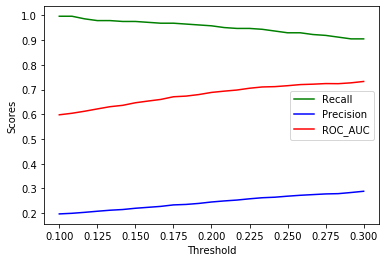

In [25]:
change_threshold(grid_log_reduced_2, threshold_list,X_test_reduced_2)

In [26]:
est_coefs = pd.Series(grid_log_reduced_2.best_estimator_.coef_[0], index=X_test_reduced_2.columns)
sortedCoefs = est_coefs.sort_values(ascending=False)
sortedCoefs.tail(50)

# sorted_df = pd.DataFrame(sortedCoefs).reset_index().rename(columns={"index":'features', 0: model_name})
# best_features = pd.concat([best_features, sorted_df], axis=1)

('below_min', 'Calcium, Total - Blood - Chemistry')             0.125346
('below_min', 'Potassium - Blood - Chemistry')                  0.110071
('abn_percent', 'Bilirubin - Urine - Hematology')               0.103399
('below_min', 'MCHC - Blood - Hematology')                      0.101740
('max', 'Sodium - Blood - Chemistry')                           0.092867
('above_max', 'Glucose - Blood - Chemistry')                    0.074130
('above_max', 'White Blood Cells - Blood - Hematology')         0.071398
('max', 'Calcium, Total - Blood - Chemistry')                   0.063956
('below_min', 'Chloride - Blood - Chemistry')                   0.061992
('abn_percent', 'Bicarbonate - Blood - Chemistry')              0.061933
('max', 'Hematocrit - Blood - Hematology')                      0.060081
('above_max', 'Phosphate - Blood - Chemistry')                  0.049718
('above_max', 'Hemoglobin - Blood - Hematology')                0.042948
insurance_Medicare                                 

In [29]:
X_train_reduced_2.shape

(6901, 63)

## Gather Metrics

In [76]:
def gather_metrics(model_list):
    '''
    Gathers metrics from models in model_list and returns a dataframe of gathered metrics.
    '''
    metrics = pd.DataFrame(columns = ['Model','F1','ROC_AUC','Recall','Accuracy','Precision'])
    
    for model, model_name, X in model_list:
        pred = model.best_estimator_.predict(X)
        
        f1 = f1_score(y_test, pred)
        roc_auc = roc_auc_score(y_test, pred)
        recall = recall_score(y_test, pred)
        accuracy = accuracy_score(y_test, pred)
        precision = precision_score(y_test, pred)
        
        metrics = metrics.append({'Model':model_name,
                                  'F1':f1,
                                  'ROC_AUC':roc_auc,
                                  'Recall':recall,
                                  'Accuracy':accuracy,
                                  'Precision':precision}
                                 ,ignore_index=True)
#         print(model_name,' processed')
    return metrics

In [87]:
model_list=[ 
            (grid_log_reduced,'post RFECV',X_test_reduced), 
            (grid_log_reduced_2, 'post lasso', X_test_reduced_2)
           ]
gather_metrics(model_list)

,Model,F1,ROC_AUC,Recall,Accuracy,Precision
0,post RFECV,0.501792,0.750786,0.739437,0.758401,0.379747
1,post lasso,0.501792,0.750786,0.739437,0.758401,0.379747


## Gather Best Features

In [113]:
gather_best_features(model_list).head(50)

,features,post RFECV,features,post lasso
0,atherosclero,0.757719,atherosclero,0.757711
1,age,0.593823,age,0.593823
2,"('max', 'Bicarbonate - Blood - Chemistry')",0.457356,"('max', 'Bicarbonate - Blood - Chemistry')",0.457339
3,"('max', 'Anion Gap - Blood - Chemistry')",0.449247,"('max', 'Anion Gap - Blood - Chemistry')",0.449258
4,ethnicity_ASIAN,0.389341,ethnicity_ASIAN,0.389336
5,"('min', 'RDW - Blood - Hematology')",0.389024,"('min', 'RDW - Blood - Hematology')",0.389030
6,"('min', 'Urea Nitrogen - Blood - Chemistry')",0.376054,"('min', 'Urea Nitrogen - Blood - Chemistry')",0.376066
7,"('min', 'White Blood Cells - Blood - Hematology')",0.317649,"('min', 'White Blood Cells - Blood - Hematology')",0.317658
8,"('min', 'Platelet Count - Blood - Hematology')",0.270690,"('min', 'Platelet Count - Blood - Hematology')",0.270688
9,ethnicity_BLACK/AFRICAN AMERICAN,0.245151,ethnicity_BLACK/AFRICAN AMERICAN,0.245149
